In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import  SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

In [165]:
df = pd.read_csv('datasets/ufc_fights.csv')
# print(df.columns)
print(', '.join(df.columns))
# print(df.head())
# print(df.info())
# print(df.describe())

RedFighter, BlueFighter, RedOdds, BlueOdds, RedExpectedValue, BlueExpectedValue, Date, Location, Country, Winner, TitleBout, WeightClass, Gender, NumberOfRounds, BlueCurrentLoseStreak, BlueCurrentWinStreak, BlueDraws, BlueAvgSigStrLanded, BlueAvgSigStrPct, BlueAvgSubAtt, BlueAvgTDLanded, BlueAvgTDPct, BlueLongestWinStreak, BlueLosses, BlueTotalRoundsFought, BlueTotalTitleBouts, BlueWinsByDecisionMajority, BlueWinsByDecisionSplit, BlueWinsByDecisionUnanimous, BlueWinsByKO, BlueWinsBySubmission, BlueWinsByTKODoctorStoppage, BlueWins, BlueStance, BlueHeightCms, BlueReachCms, BlueWeightLbs, RedCurrentLoseStreak, RedCurrentWinStreak, RedDraws, RedAvgSigStrLanded, RedAvgSigStrPct, RedAvgSubAtt, RedAvgTDLanded, RedAvgTDPct, RedLongestWinStreak, RedLosses, RedTotalRoundsFought, RedTotalTitleBouts, RedWinsByDecisionMajority, RedWinsByDecisionSplit, RedWinsByDecisionUnanimous, RedWinsByKO, RedWinsBySubmission, RedWinsByTKODoctorStoppage, RedWins, RedStance, RedHeightCms, RedReachCms, RedWeightLb

In [131]:
#analyze and handle missing data

def missing_value_analysis(df):
    missing_values = df.isnull().sum()
    missing_values_percentage = (missing_values / len(df)) * 100
    missing_values_table = pd.concat([missing_values, missing_values_percentage], axis=1)
    missing_values_table = missing_values_table.rename(columns={0: 'Missing Values', 1: 'Percentage'})

    return missing_values_table[missing_values_table['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)


missing_data = missing_value_analysis(df)
print(missing_data)

                       Missing Values  Percentage
BWFeatherweightRank              6527   99.984681
RWFeatherweightRank              6519   99.862132
BPFPRank                         6461   98.973652
BWFlyweightRank                  6455   98.881740
RWFlyweightRank                  6432   98.529412
BWStrawweightRank                6428   98.468137
BWBantamweightRank               6421   98.360907
BWelterweightRank                6409   98.177083
BBantamweightRank                6409   98.177083
BLightHeavyweightRank            6408   98.161765
BLightweightRank                 6408   98.161765
BFeatherweightRank               6404   98.100490
BFlyweightRank                   6398   98.008578
BMiddleweightRank                6391   97.901348
RWStrawweightRank                6382   97.763480
BHeavyweightRank                 6380   97.732843
RWBantamweightRank               6374   97.640931
RFeatherweightRank               6351   97.288603
RBantamweightRank                6347   97.227328


In [132]:
def create_rank_categories(df, rank_column):
    if rank_column not in df.columns or not pd.api.types.is_numeric_dtype(df[rank_column]):
        return None
    
    rank_values = df[rank_column].astype(float)
    
    # Create a mask for NaN values
    na_mask = rank_values.isna()
    
    # Initialize result series with proper size (using strings, not category yet)
    result = pd.Series(index=rank_values.index, dtype='object')
    
    # Assign categories manually using conditions instead of pd.cut to avoid date conversion
    result[(rank_values >= 0) & (rank_values <= 10)] = 'Top 10'
    result[(rank_values > 10) & (rank_values <= 25)] = 'Rank 11-25'  
    result[(rank_values > 25) & (rank_values <= 50)] = 'Rank 26-50'  
    result[(rank_values > 50) & (rank_values <= 100)] = 'Rank 51-100' 
    result[(rank_values > 100) & (~na_mask)] = 'Rank 100+' 
    # Assign 'Unranked' only to actual NaN positions
    result[na_mask] = 'Unranked'
    
    all_categories = ['Top 10', 'Rank 11-25', 'Rank 26-50', 'Rank 51-100', 'Rank 100+', 'Unranked']
    return pd.Categorical(result, categories=all_categories)

In [133]:
# Handle missing values
def handle_missing_values(df):
   
    df_processed = df.copy()
    
    # 1.Drop unnecessary columns
    columns_to_drop = ['Country', 'Location', 'FinishRoundTime', 'EmptyArena','RedFighter', 'BlueFighter']
    df_processed = df_processed.drop(columns=[col for col in columns_to_drop if col in df_processed.columns])
    print(f"Dropped unnecessary columns")

    # 2.Handle FinishDetails (55.70% missing)
    print("Creating indicator for FinishDetails column")
    df_processed['FinishDetails_present'] = df_processed['FinishDetails'].notnull().astype(int)
    df_processed['FinishDetails_clean'] = df_processed['FinishDetails'].fillna("Not Recorded")
    df_processed = df_processed.drop(columns=['FinishDetails'])
    
    # 3.Handle Match Weight Class Rank columns
    print("Creating indicators and categories for BMatchWCRank and RMatchWCRank")
    # For Blue corner
    df_processed['BMatchWCRank_present'] = df_processed['BMatchWCRank'].notnull().astype(int)
    # For Red corner
    df_processed['RMatchWCRank_present'] = df_processed['RMatchWCRank'].notnull().astype(int)
    
    # 4.Create ordinal categories for ranks
     # Create correct ordinal categories for ranks using the improved function
    df_processed['BMatchWCRank_cat'] = create_rank_categories(df_processed, 'BMatchWCRank')
    df_processed['RMatchWCRank_cat'] = create_rank_categories(df_processed, 'RMatchWCRank')
    
    # 5.Handle extreme missing values (>95%) - mostly weight class rankings
    extreme_missing_cols = missing_data[missing_data['Percentage'] > 95].index.tolist()
    print(f"Creating binary indicators for {len(extreme_missing_cols)} columns with >95% missing values")
    
    for col in extreme_missing_cols:
        df_processed[f"{col}_present"] = df_processed[col].notnull().astype(int)
    
    # 6.Create aggregated indicators for weight class rankings
    ranking_cols = [col for col in df_processed.columns if 'Rank' in col and col in extreme_missing_cols]
    
    # Aggregate by corner (blue/red)
    if ranking_cols:
        blue_rank_cols = [col for col in ranking_cols if col.startswith('B')]
        red_rank_cols = [col for col in ranking_cols if col.startswith('R')]
        
        if blue_rank_cols:
            df_processed['blue_has_any_rank'] = df_processed[blue_rank_cols].notnull().any(axis=1).astype(int)
        if red_rank_cols:
            df_processed['red_has_any_rank'] = df_processed[red_rank_cols].notnull().any(axis=1).astype(int)


    df_processed = df_processed.drop(columns=['BMatchWCRank', 'RMatchWCRank'] + extreme_missing_cols)


     # 7. Handle columns with low data values missing (<21%)
    low_missing_cols = missing_data[missing_data['Percentage'] < 21].index.tolist()
    
    print(f"Standard imputation for {len(low_missing_cols)} columns with <23% missing values")
    
    for col in low_missing_cols:
        if col in df_processed.columns:
            # Create a 2D array for the imputer
            values = df_processed[col].values.reshape(-1, 1)
            
            # For numeric columns
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                # Initialize the SimpleImputer with median strategy
                imputer = SimpleImputer(strategy='median')
                imputed_values = imputer.fit_transform(values)
                median_val = imputer.statistics_[0]
                df_processed[col] = imputed_values.flatten()
                print(f"  - Imputed {col} with median: {median_val}")

            # For categorical/object columns
            else:
                # Initialize the SimpleImputer with most_frequent strategy
                imputer = SimpleImputer(strategy='most_frequent')
                imputed_values = imputer.fit_transform(values)
                mode_val = imputer.statistics_[0] if not pd.isna(imputer.statistics_[0]) else "Unknown"
                df_processed[col] = imputed_values.flatten()
                print(f"  - Imputed {col} with mode: {mode_val}")      
    
    return df_processed

df_processed = handle_missing_values(df)
          

Dropped unnecessary columns
Creating indicator for FinishDetails column
Creating indicators and categories for BMatchWCRank and RMatchWCRank
Creating binary indicators for 26 columns with >95% missing values
Standard imputation for 25 columns with <23% missing values
  - Imputed BKOOdds with median: 525.0
  - Imputed BSubOdds with median: 1000.0
  - Imputed RSubOdds with median: 750.0
  - Imputed RKOOdds with median: 420.0
  - Imputed BlueDecOdds with median: 350.0
  - Imputed RedDecOdds with median: 250.0
  - Imputed BlueAvgSigStrLanded with median: 9.28
  - Imputed BlueAvgTDPct with median: 0.33
  - Imputed BlueAvgTDLanded with median: 1.0
  - Imputed BlueAvgSubAtt with median: 0.3
  - Imputed BlueAvgSigStrPct with median: 0.46
  - Imputed FinishRound with median: 3.0
  - Imputed TotalFightTimeSecs with median: 900.0
  - Imputed RedAvgSigStrLanded with median: 15.6667
  - Imputed RedAvgTDPct with median: 0.338
  - Imputed RedAvgSigStrPct with median: 0.46
  - Imputed RedAvgTDLanded w

In [ ]:
# Verify results
print("\nVerifying results after processing")
missing_after = missing_value_analysis(df_processed.drop([col for col in df_processed.columns 
                                       if col.endswith('_present') or col.endswith('_cat') or col.endswith('_clean')], axis=1))
print("Original columns with missing values after processing:")
if len(missing_after) > 0:
    display(missing_after)
else:
    print("No missing values remain in processed original columns!")

if 'BMatchWCRank_cat' in df_processed.columns:
        print("\nBMatchWCRank_cat distribution:")
        print(df_processed['BMatchWCRank_cat'].value_counts(dropna=False))
    
if 'RMatchWCRank_cat' in df_processed.columns:
        print("\nRMatchWCRank_cat distribution:")
        print(df_processed['RMatchWCRank_cat'].value_counts(dropna=False))

# Save processed dataset
df_processed.to_csv('datasets/processed_fighting_data.csv', index=False)
print("\nProcessed dataset saved!")



Verifying results after processing
Original columns with missing values after processing:
No missing values remain in processed original columns!

BMatchWCRank_cat distribution:
BMatchWCRank_cat
Unranked       5328
Top 10          784
Rank 11-25      416
Rank 26-50        0
Rank 51-100       0
Rank 100+         0
Name: count, dtype: int64

RMatchWCRank_cat distribution:
RMatchWCRank_cat
Unranked       4749
Top 10         1300
Rank 11-25      479
Rank 26-50        0
Rank 51-100       0
Rank 100+         0
Name: count, dtype: int64

Processed dataset saved!


Winner
Red     3787
Blue    2741
Name: count, dtype: int64


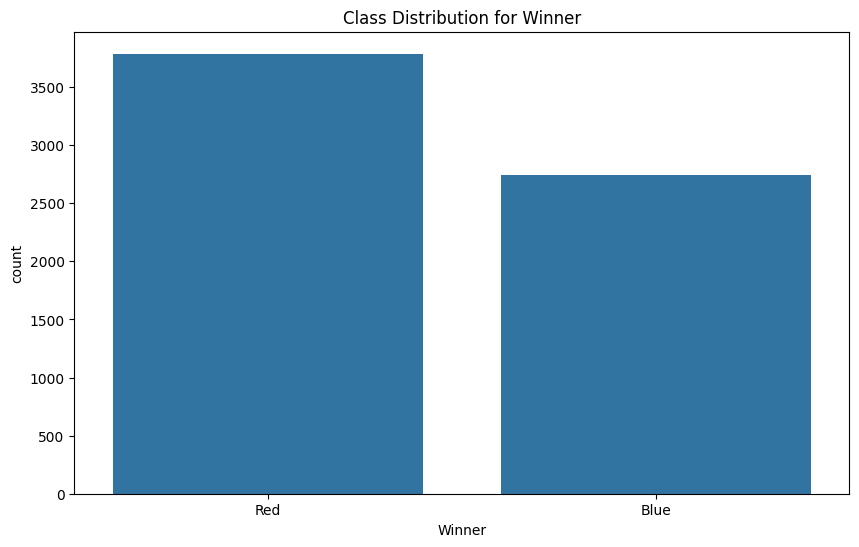


Class distribution after undersampling:
Counter({'Blue': 2741, 'Red': 2741})


C:\Users\manuj\AppData\Local\Temp\ipykernel_1680\2839325734.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  under_df['Winner'] = y_under


Winner
Blue    2741
Red     2741
Name: count, dtype: int64


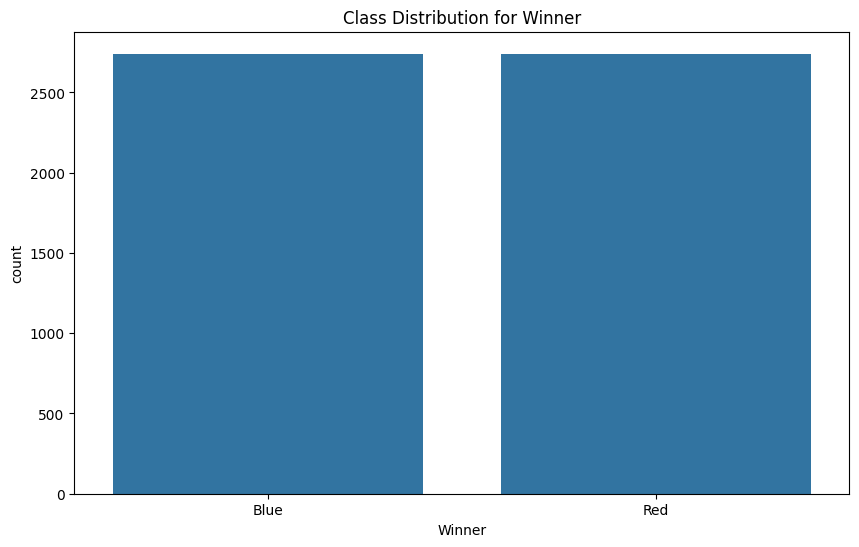

In [ ]:
# Check the dataset for Imabalances
df = pd.read_csv('datasets/processed_fighting_data.csv')
winner_counts = df['Winner'].value_counts()
print(winner_counts)
# Visualize the class imbalance
plt.figure(figsize=(10, 6))
sns.countplot(x='Winner', data=df)
plt.title('Class Distribution for Winner')
plt.show()


X = df.drop(columns=['Winner']) 
y = df['Winner']  

# Handle the winner class imbalance using undersampling of the majority
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)

print("\nClass distribution after undersampling:")
print(Counter(y_under))

under_df = pd.DataFrame(X_under, columns=X.columns)
under_df['Winner'] = y_under
under_df.to_csv('datasets/winner_balanced_ufc_dataset.csv', index=False)


df = pd.read_csv('datasets/winner_balanced_ufc_dataset.csv')
winner_counts = df['Winner'].value_counts()
print(winner_counts)
# Visualize the class imbalance
plt.figure(figsize=(10, 6))
sns.countplot(x='Winner', data=df)
plt.title('Class Distribution for Winner')
plt.show()


In [ ]:
df = pd.read_csv('datsets/winner_balanced_ufc_dataset.csv')

# 1. Betting Odds Ratio
df['OddsRatio'] = df['RedOdds'] / df['BlueOdds']

# 2. Experience Metrics
df['RedExperience'] = df['RedWins'] + df['RedLosses'] + df['RedDraws']
df['BlueExperience'] = df['BlueWins'] + df['BlueLosses'] + df['BlueDraws']
df['ExperienceDifference'] = df['RedExperience'] - df['BlueExperience']

# 3. Win Percentages
eps = 1e-10
df['RedWinPercentage'] = df['RedWins'] / (df['RedWins'] + df['RedLosses'] + df['RedDraws'] + eps)
df['BlueWinPercentage'] = df['BlueWins'] / (df['BlueWins'] + df['BlueLosses'] + df['BlueDraws'] + eps)
df['WinPercentageDifference'] = df['RedWinPercentage'] - df['BlueWinPercentage']

# 4. Form Metrics
df['RedForm'] = df['RedCurrentWinStreak'] - df['RedCurrentLoseStreak']
df['BlueForm'] = df['BlueCurrentWinStreak'] - df['BlueCurrentLoseStreak']
df['FormDifference'] = df['RedForm'] - df['BlueForm']

# 5. Fighting Style Indicators
df['RedStrikerScore'] = df['RedAvgSigStrLanded'] * df['RedAvgSigStrPct']
df['BlueStrikerScore'] = df['BlueAvgSigStrLanded'] * df['BlueAvgSigStrPct']
df['RedGrapplerScore'] = df['RedAvgTDLanded'] * df['RedAvgTDPct'] + df['RedAvgSubAtt']
df['BlueGrapplerScore'] = df['BlueAvgTDLanded'] * df['BlueAvgTDPct'] + df['BlueAvgSubAtt']
df['StyleAdvantage'] = (df['RedStrikerScore'] - df['RedGrapplerScore']) - (df['BlueStrikerScore'] - df['BlueGrapplerScore'])

# 6. Finish Rate
df['RedFinishRate'] = np.where(df['RedWins'] > 0, 
                              (df['RedWinsByKO'] + df['RedWinsBySubmission']) / df['RedWins'], 
                              0)
df['BlueFinishRate'] = np.where(df['BlueWins'] > 0, 
                               (df['BlueWinsByKO'] + df['BlueWinsBySubmission']) / df['BlueWins'], 
                               0)
df['FinishRateDifference'] = df['RedFinishRate'] - df['BlueFinishRate']

# 7. Age-Adjusted Performance
df['RedAgeFactor'] = 1 - abs(df['RedAge'] - 30) / 15  # Simple linear decay
df['BlueAgeFactor'] = 1 - abs(df['BlueAge'] - 30) / 15
df['AgeFactorDifference'] = df['RedAgeFactor'] - df['BlueAgeFactor']

# 8. Betting Confidence
if 'RedExpectedValue' in df.columns and 'BlueExpectedValue' in df.columns:
    df['RedBettingConfidence'] = abs(df['RedOdds'] - df['RedExpectedValue'])
    df['BlueBettingConfidence'] = abs(df['BlueOdds'] - df['BlueExpectedValue'])

# 9. Composite Indicators
df['RedPerformanceScore'] = (df['RedWinPercentage'] * df['RedAgeFactor'] * 
                            (1 + 0.1 * df['RedCurrentWinStreak'] - 0.15 * df['RedCurrentLoseStreak']))
df['BluePerformanceScore'] = (df['BlueWinPercentage'] * df['BlueAgeFactor'] * 
                             (1 + 0.1 * df['BlueCurrentWinStreak'] - 0.15 * df['BlueCurrentLoseStreak']))
df['PerformanceScoreDiff'] = df['RedPerformanceScore'] - df['BluePerformanceScore']

# 10. Outcome Prediction Probabilities
df['RedImpliedProbability'] = 1 / df['RedOdds']
df['BlueImpliedProbability'] = 1 / df['BlueOdds']

# Save the final dataset
df.to_csv('datasets/final_ufc_dataset.csv', index=False)

In [30]:
#Feature standardization
df = pd.read_csv('datasets/final_ufc_dataset.csv')


numerical_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] ] 
scaler = StandardScaler()

df[numerical_features] = scaler.fit_transform(df[numerical_features])
print("Features have been standardized.")

Features have been standardized.


In [31]:
# Encoding of categorical features
df_noDate = df.drop(columns=['Date'])
X = df_noDate.drop('Winner', axis=1)
y = df_noDate['Winner']
y = y.map({'Red': 1, 'Blue': 0})

X_processed = X.copy()

cat_cols = X_processed.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

print(cat_cols)

if cat_cols:
    X_processed = pd.get_dummies(X_processed, columns=cat_cols, drop_first=True)


['WeightClass', 'Gender', 'BlueStance', 'RedStance', 'BetterRank', 'Finish', 'FinishDetails_clean', 'BMatchWCRank_cat', 'RMatchWCRank_cat']


Top selected features: ['RedOdds', 'BlueOdds', 'RedExpectedValue', 'BlueExpectedValue', 'RedCurrentWinStreak', 'RedAvgSigStrPct', 'RedAvgTDLanded', 'RedLosses', 'RedAge', 'BlueAge', 'WinStreakDif', 'AvgTDDif', 'RedDecOdds', 'BlueDecOdds', 'RSubOdds', 'BSubOdds', 'RKOOdds', 'BKOOdds', 'OddsRatio', 'RedWinPercentage', 'WinPercentageDifference', 'RedForm', 'FormDifference', 'RedGrapplerScore', 'RedBettingConfidence', 'BlueBettingConfidence', 'RedPerformanceScore', 'PerformanceScoreDiff', 'RedImpliedProbability', 'BlueImpliedProbability']


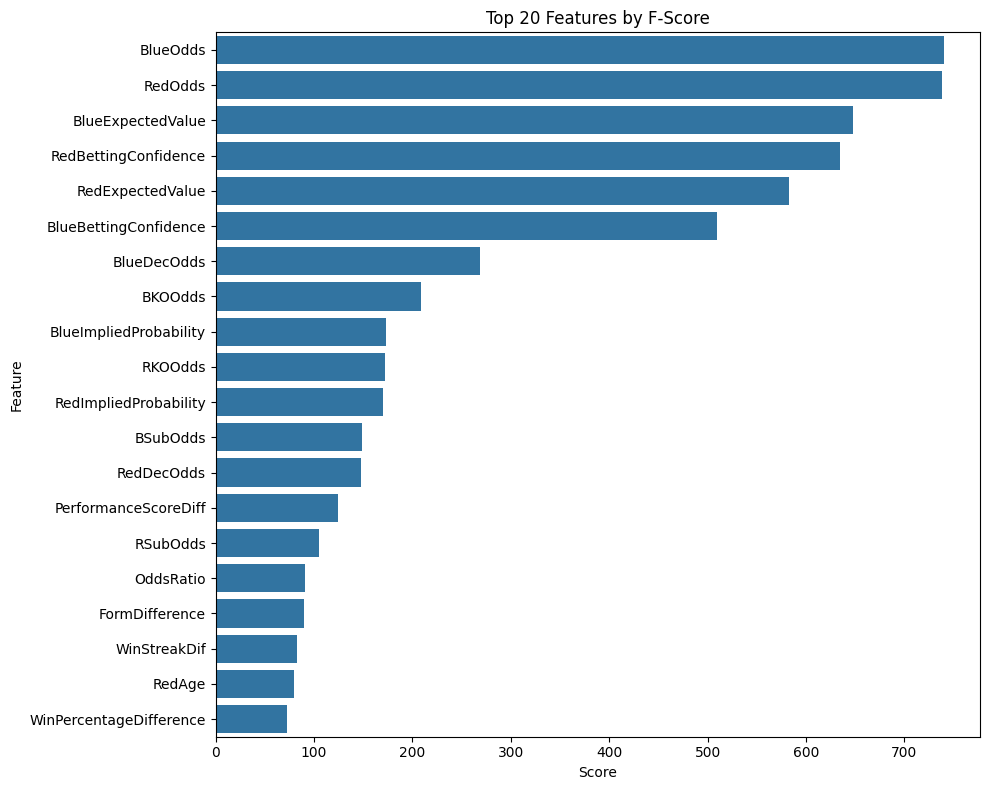

In [32]:

selector = SelectKBest(f_classif, k=30)
X_selected_array = selector.fit_transform(X_processed, y)

# Get selected feature names
selected_features = X_processed.columns[selector.get_support()]
print("Top selected features:", selected_features.tolist())

# Display feature scores
feature_scores = pd.DataFrame({
    'Feature': X_processed.columns,
    'Score': selector.scores_
})
top_features = feature_scores.sort_values('Score', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Score', y='Feature', data=top_features)
plt.title('Top 20 Features by F-Score')
plt.tight_layout()
plt.show()


In [45]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [ ]:
# 1. Train a Random Forest model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

In [ ]:
# 2.Train a LightGBM model

model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,  
    boosting_type='gbdt', 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [28]:
# 3. Train a XGBoost model
model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# 4. Train an ensemble model using StackingClassifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42,
    n_jobs=-1)),
    ('xgb', xgb.XGBClassifier( n_estimators=100,
    learning_rate=0.1,
    max_depth=1,  
    boosting_type='gbdt', 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)),
    ('lgb', lgb.LGBMClassifier(learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42))
]

model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42,max_iter=150, multi_class='ovr',solver='saga'),
    cv=5
)

model.fit(X_train, y_train)

XGBoostError: value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy

In [43]:
#5. Train a Logistic Regression model
model = LogisticRegression( random_state=42,max_iter=150, multi_class='ovr',solver='saga')
model.fit(X_train, y_train)

d:\Dev\AI\Octagon-Oracle\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Dev\AI\Octagon-Oracle\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=150, multi_class='ovr', random_state=42,
                   solver='saga')

Model Accuracy: 0.6490

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65       559
           1       0.64      0.67      0.65       538

    accuracy                           0.65      1097
   macro avg       0.65      0.65      0.65      1097
weighted avg       0.65      0.65      0.65      1097



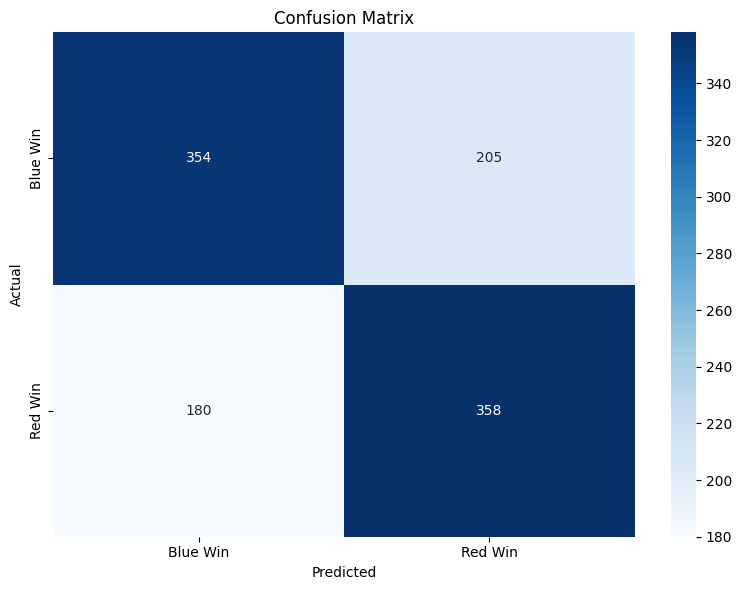

In [44]:

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Blue Win', 'Red Win'], 
            yticklabels=['Blue Win', 'Red Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()